In [1]:
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

import os
import pandas as pd

DATADIR="/storage/s1saini/manuscript_strsnp/fig3/ssc-imputation/"

def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None, label="_nolegend_"):
    ax = ax if ax is not None else plt.gca()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    base_line, = ax.plot(x, y, color=color, label=label)
    if color is None:
        color = base_line.get_color()
    ax.fill_between(x, ymax, ymin, facecolor=color, alpha=alpha_fill)

def GetError(x, num):
    snp1 = x["snppanel"].split("|")
    snp2 = x["snp10x"].split("|")
    str1 = x["strpanel"].split("|")
    str2 = x["str10x"].split("|")
    str1 = [int(item) for item in str1]
    str2 = [int(item) for item in str2]
    if snp1[0] == snp2[0]:
        if num == 1: return str1[0]-str2[0]
        else: return str1[1]-str2[1]
    else: 
        if num == 1: return str1[1]-str2[0]
        else: return str1[0]-str2[1]
        
def Concordant(gt1, gt2):
    gt1 = gt1.split("|")
    gt2 = gt2.split("|")
    if gt1[0] == gt2[0] and gt1[1] == gt2[1]: return True
    elif gt1[1] == gt2[0] and gt1[0] == gt2[1]: return True
    else: return False
    
def IsHet(gt):
    gt = gt.split("|")
    return gt[0] != gt[1]

# Get phase info
def GetPhase(x):
    snp1 = x["snppanel"].split("|")
    snp2 = x["snp10x"].split("|")
    str1 = x["strpanel"].split("|")
    str2 = x["str10x"].split("|")
    if snp1[0] == snp2[0]:
        return str1[0]==str2[0] and str1[1]==str2[1]
    else: return str1[1]==str2[0] and str1[0]==str2[1]

Populating the interactive namespace from numpy and matplotlib


In [2]:
tenx = pd.read_csv("/storage/mgymrek/ssc-imputation/na12878-10x/na12878_panel_vs_10x.tab", sep="\t")
tenx["locus"] = tenx.apply(lambda x: str(x["chrom"])+":"+str(x["strpos"]), 1)

sscloo = pd.read_csv(os.path.join(DATADIR, "loo","l1o.ALL.chr.csv")).drop(['pos'], axis=1).drop_duplicates(subset=['str'])
id_start = pd.read_csv(os.path.join(DATADIR, "loo", "ALL.START_ID.txt"), delim_whitespace=True, names=["str","locus"]).drop_duplicates(subset=['locus'])
sscloo = pd.merge(sscloo, id_start, on=["str"])

tenx = pd.merge(tenx, sscloo[["locus","loo_concordance"]], on=["locus"])

tenx["str.conc"] = tenx.apply(lambda x: Concordant(x["strpanel"], x["str10x"]), 1)
tenx["snp.conc"] = tenx.apply(lambda x: Concordant(x["snppanel"], x["snp10x"]), 1)
tenx["str.het"] = tenx.apply(lambda x: IsHet(x["str10x"]), 1)

print("Before filtering, have %s strs"%tenx.shape[0])
tenx_filtered = tenx[tenx["snp.conc"]]
print("After filtering for discordant SNP, have %s strs"%tenx_filtered.shape[0])

# Get size of errors
tenx_filtered["error1"] = tenx_filtered.apply(lambda x: GetError(x, 1), 1)
tenx_filtered["error2"] = tenx_filtered.apply(lambda x: GetError(x, 2), 1)

# Get phase
tenx_filtered["phase.correct"] = tenx_filtered.apply(lambda x: GetPhase(x), 1)

Before filtering, have 118353 strs
After filtering for discordant SNP, have 116764 strs


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
# Stats on STR genotype concordance
print("Overall STR genotype concordance %s"%np.mean(tenx_filtered["str.conc"]))

# Stats on per-allele concordance
print("Allele concordance %s"%np.mean(list(tenx_filtered["error1"]==0)+list(tenx_filtered["error2"]==0)))
# Of het STRs called correctly, how many had correct phase
x = np.mean(tenx_filtered[tenx_filtered["str.conc"] & tenx_filtered["str.het"]]["phase.correct"])
print("How many phased correctly %s"%x)

Overall STR genotype concordance 0.9270237401938953
Allele concordance 0.9604415744578808
How many phased correctly 0.9975461179154917


In [10]:
print("number of calls compared: %s"%tenx_filtered.shape[0])
print("number of hets: %s"%tenx_filtered[tenx_filtered["str.het"]].shape[0])
print("number of hets correct: %s"%tenx_filtered[(tenx_filtered["str.het"]) & (tenx_filtered["str.conc"])].shape[0])

number of calls compared: 116764
number of hets: 53243
number of hets correct: 46457


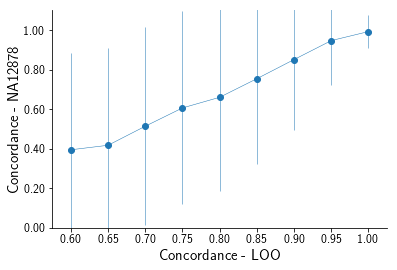

In [4]:
# Stratify by LOO concordance
true_color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
CONCBIN=0.05

means = []
sds = []
nums = []
cbs_plot = []
cbs = [round(item, 2) for item in np.arange(0.4, 1+CONCBIN, CONCBIN)]
for cb in cbs:
    x = np.array(tenx_filtered[(tenx_filtered["loo_concordance"]>=cb) & (tenx_filtered["loo_concordance"]<cb+CONCBIN)]["str.conc"])
    if len(x)>=100:
        means.append(np.mean(x))
        sds.append(np.sqrt(np.var(x)))
        cbs_plot.append(cb)
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(cbs_plot, means, yerr=sds, marker="o", linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Concordance - LOO", size=15)
ax.set_ylabel("Concordance - NA12878", size=15)
ax.set_xlim(left=cbs_plot[0]-CONCBIN/2, right=1+CONCBIN/2)
ax.set_ylim(bottom=0, top=1.1)
ax.set_xticklabels(["%.2f"%item for item in ax.get_xticks()], size=12)
ax.set_yticklabels(["%.2f"%item for item in ax.get_yticks()], size=12);
fig.savefig("../haplotype_paper/FiguresRevision/pdfs/na12878_10x_conc.pdf")

In [5]:
# Is concordance correlated with distance to nearest het SNP? moderately
import scipy.stats
tenx_filtered["snp.dist"] = tenx_filtered.apply(lambda x: abs(x["snppos"]-x["strpos"]), 1)
tenx_filtered2 = tenx_filtered[tenx_filtered["snp.dist"]<=50000]
scipy.stats.pearsonr(tenx_filtered2["snp.dist"], tenx_filtered2["str.conc"])

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(-0.04077860031986612, 3.88275189168836e-44)

In [6]:
# Look at CODIS + other markers
codis_markers = ["5:149455884","13:82722160","18:60948895", \
                 "19:30417140","3:45582231","5:123111245", \
                "7:83789542","8:125907107","4:155508888", \
                "15:97374244","11:2192318","2:1493425","22:46659670"]
tenx_filtered[tenx_filtered["locus"].apply(lambda x: x in codis_markers)]

,chrom,strpos,snppos,strpanel,str10x,snppanel,snp10x,locus,loo_concordance,str.conc,snp.conc,str.het,error1,error2,phase.correct,snp.dist
57792,7,83789542,83789601,-20|-16,-20|-12,1|0,1|0,7:83789542,0.708768,False,True,True,0,-4,False,59
88941,13,82722160,82722134,0|4,0|4,0|1,0|1,13:82722160,0.685804,True,True,True,0,0,True,26
118161,22,46659670,46659579,0|4,0|4,0|1,0|1,22:46659670,0.994781,True,True,True,0,0,True,91


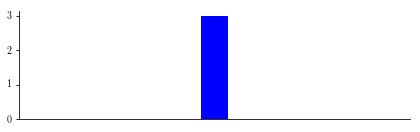

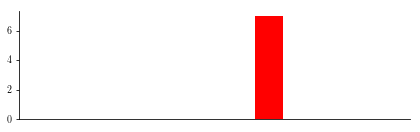

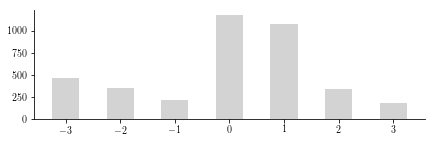

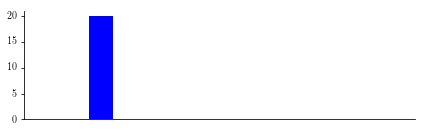

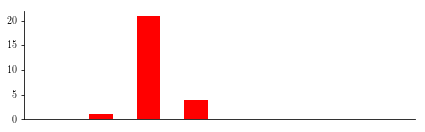

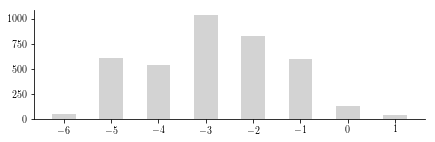

In [7]:
# Plot examples for panel
width=0.5

loci = [("13:82722160", 4), ("7:83789542", 4)]
for locus, period in loci:
    chrom, start = locus.split(":")
    lines = open("%s_%s_panel.txt"%(chrom, start)).readlines()
    alleles1 = [int(item)/period for item in lines[0].strip().split()]
    alleles2 = [int(item)/period for item in lines[1].strip().split()]
    allelesALL = [int(item)/period for item in lines[2].strip().split()]

    vals = [item for item in sorted(list(set(allelesALL))) if allelesALL.count(item)>=10]
    counts1 = [alleles1.count(item) for item in vals]
    counts2 = [alleles2.count(item) for item in vals]
    countsALL = [allelesALL.count(item) for item in vals]
    fig = plt.figure()
    fig.set_size_inches((7, 2))
    ax = fig.add_subplot(111)
    ax.bar(vals, counts1, color="blue", width=width)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([])
    fig.savefig("../haplotype_paper/FiguresRevision/pdfs/%s_%s_hap1.pdf"%(chrom, start))
    
    fig = plt.figure()
    fig.set_size_inches((7, 2))
    ax = fig.add_subplot(111)
    ax.bar(vals, counts2, color="red", width=width)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([])
    fig.savefig("../haplotype_paper/FiguresRevision/pdfs/%s_%s_hap2.pdf"%(chrom, start))

    fig = plt.figure()
    fig.set_size_inches((7, 2))
    ax = fig.add_subplot(111)
    ax.bar(vals, countsALL, color="lightgray", width=width)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(vals)
    fig.savefig("../haplotype_paper/FiguresRevision/pdfs/%s_%s_all.pdf"%(chrom, start))
    #ax.bar([item+width for item in vals], counts2, width=width, color="blue")